# Load packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install scanpy
!pip install matplotlib==3.1.3
!pip install -U tensorflow

import numpy as np 
import pandas as pd 
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import scipy
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 6.6 MB/s 
     |████████████████████████████████| 96 kB 2.7 MB/s 
     |████████████████████████████████| 11.2 MB 50.7 MB/s 
     |████████████████████████████████| 88 kB 8.7 MB/s 
     |████████████████████████████████| 944 kB 22.5 MB/s 
     |████████████████████████████████| 1.1 MB 61.5 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=23f53c9d874282751312fea4078c0787fe7c819fc042475d1c9d5c2721e9cc1c
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=772df9b0d26130aee3cee0677eea91d8b01625c3a32dedbc1e33a696f8f81bed
  Stored in directory: /root/.cache/pip/wheels/7f/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 8.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.6 kB/s 
     |████████████████████████████████| 1.6 MB 43.8 MB/s 
     |████████████████████████████████| 5.8 MB 62.4 MB/s 
     |████████████████████████████████| 438 kB 38.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

# Define VAE class

In [ ]:
# Create weight constraint so that marker gene weights are non-negative
class NonNegative(tf.keras.constraints.Constraint):

  def __init__(self, weight_mask):
    self.marker_weight_mask = weight_mask
    self.NonMarker_weight_mask = 1 - weight_mask

# Multiply the weight matrix by weight mask
  def __call__(self, w):
    marker_sparse_w = w * self.marker_weight_mask                                                            # make marker weights sparse
    NonNeg_marker_sparse_w = marker_sparse_w * tf.cast(tf.math.greater_equal(marker_sparse_w, 0.), w.dtype)  # sparse * non-negativity constraint 
    NonMarker_sparse_w = w * self.NonMarker_weight_mask                                                      # make non-marker weights sparse
    return NonNeg_marker_sparse_w + NonMarker_sparse_w                                                       # add non-marker weights regardless of non-negativity

In [ ]:
class Autoencoder(Model):
    def __init__(self, num_cell_types, num_genes, reg_penalties, weight_mask):
        super(Autoencoder, self).__init__()  
        self.reg_penalties = reg_penalties
        self.encoder_weight_mask = tf.keras.backend.constant(weight_mask) 
        self.decoder_weight_mask = tf.keras.backend.constant(weight_mask.T)
        self.mean_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer, 
                      kernel_constraint=NonNegative(self.encoder_weight_mask)),
        ])
        self.var_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer, 
                      kernel_constraint=NonNegative(self.encoder_weight_mask)),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear', 
                      kernel_regularizer=self.decoder_marker_gene_regularizer, 
                      kernel_constraint=NonNegative(self.decoder_weight_mask))
        ])

    def reparameterization(self, mean, var):
        epsilon = tf.random.normal(shape = [mean.shape[1]])             
        z = mean + (var*epsilon)                       
        return z
        
    def call(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        z = self.reparameterization(mean, tf.exp(0.5 * log_var))
        p = tf.keras.activations.softmax(z)
        decoded = self.decoder(p)
        return decoded

    def embed(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        var = tf.exp(0.5 * log_var)
        return tf.keras.activations.softmax(mean), mean, var

    def encoder_marker_gene_regularizer(self, w):
        return tf.reduce_sum(self.reg_penalties * tf.square(w))

    def decoder_marker_gene_regularizer(self, w):
        return tf.reduce_sum(self.reg_penalties.T * tf.square(w))

# Define t-test computation function

In [ ]:
def Compute_tTest(mean1,var1,mean2,var2,n):
  tScore = (mean1-mean2) / math.sqrt((var1+var2)/n)
  DegFreedom = ((((var1**2)+(var2**2))/n)**2) / ((((var1**2)+(var2**2))/(n**2))/(n-1))
  return scipy.stats.t.sf(abs(tScore), df=DegFreedom)

# Pancreas

In [ ]:
# Load data matrix 
Pancreas_adata = sc.read_text('/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_LogX_CellCycleRegressedOut.txt', delimiter = '\t', first_column_names=None)
sc.pp.scale(Pancreas_adata) # scale data 

# Load ground truth cell type labels 
PancreasMetadata = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/PancreasMetadata.csv")
Pancreas_adata.obs['Cell Type'] = PancreasMetadata['Cell type'].values

# Load cell barcodes 
PancreasCellID = []
for item in PancreasMetadata['Cell ID'].values:
  PancreasCellID.append(item)
Pancreas_adata.obs_names = PancreasCellID

# Load gene list 
PancreasGenes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_Genelist.txt",header=None)
PancreasGenelist = []
for item in PancreasGenes.values.tolist():
  PancreasGenelist.append(item[0])
Pancreas_adata.var_names = PancreasGenelist

Pancreas_adata

AnnData object with n_obs × n_vars = 2209 × 26179
    obs: 'Cell Type'
    var: 'mean', 'std'

In [ ]:
# Load Panglao DB marker gene list 
MarkerGeneList = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/PanglaoDB_Markers.tsv",sep='\t')

# Use Panglao DB to create list of human pancreas markers 
PancreasMarkers = MarkerGeneList.iloc[np.asarray(np.where((MarkerGeneList['organ'] == 'Pancreas') & (MarkerGeneList['species'] != 'Mm')))[0,:],:]

# Manually get rid of unwanted cell types: Pancreatic progenitor cells and Peri-islet Schwann cells 
PancreasMarkers = PancreasMarkers.iloc[np.asarray(np.where(PancreasMarkers['cell type'] != 'Pancreatic progenitor cells'))[0,:],:]
PancreasMarkers = PancreasMarkers.iloc[np.asarray(np.where(PancreasMarkers['cell type'] != 'Peri-islet Schwann cells'))[0,:],:]

# Manually add cell types: endocrine, endothelial, mast, MHC (dendritic, macrophages, B cells)
# unclassified exocrine cells are also acinar cells; co-expression is not a defined cell type
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Enteroendocrine cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Endothelial cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Mast cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Dendritic cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Macrophages'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'B cells'))[0,:],:])

# Replace 'B cells', 'Macrophages' and 'Dendritic cells' labels with 'MHC'
PancreasMarkers['cell type'] = PancreasMarkers['cell type'].replace(['B cells', 'Macrophages', 'Dendritic cells'],
                                                                    'MHC')

# Only include genes found in the data gene list 
PanglaoDB_Pancreas = PancreasMarkers['official gene symbol'] # isolate gene names from the PancreasMarkers dataframe 
PanglaoDB_Pancreas = list(set(PanglaoDB_Pancreas) & set(Pancreas_adata.var_names)) # overlap between dataset gene list and the PanglaoDB set 

# Create a variable list for input genes / features 
Panglao_Input = []

for i in range(Pancreas_adata.shape[1]):
  if Pancreas_adata.var_names[i] in set(PanglaoDB_Pancreas):
    Panglao_Input.append(True)
  else: 
    Panglao_Input.append(False)

Pancreas_adata.var['input_features'] = Panglao_Input

# Create anndata input for the model by filtering Pancreas_adata
Pancreas_input = Pancreas_adata[:,Pancreas_adata.var['input_features']]
Pancreas_input

View of AnnData object with n_obs × n_vars = 2209 × 882
    obs: 'Cell Type'
    var: 'mean', 'std', 'input_features'

In [ ]:
# Creating weight mask for marker genes
marker_genes = Pancreas_input.var_names
cell_types = pd.unique(PancreasMarkers['cell type'])

marker_gene_cell_type_weight_mask = np.zeros((len(marker_genes), len(cell_types)))
for i, gene in enumerate(marker_genes):
  for j, cell_type in enumerate(cell_types):
    is_marker_gene_for_cell_type = \
      PancreasMarkers[(PancreasMarkers['official gene symbol'] == gene) & 
                      (PancreasMarkers['cell type'] == cell_type)].shape[0] > 0
    if is_marker_gene_for_cell_type:   # Mask = 1
      marker_gene_cell_type_weight_mask[i, j] = 1
    else:                              # Mask = 0
      marker_gene_cell_type_weight_mask[i, j] = 0

# Creating marker gene biased regularization mask 
marker_gene_cell_type_reg_penalties = 1 - marker_gene_cell_type_weight_mask

In [ ]:
# Train the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
NumPancreasCellTypes = len(PancreasMarkers['cell type'].unique())
num_genes = Pancreas_input.shape[1]
autoencoder = Autoencoder(NumPancreasCellTypes, num_genes, 
                          marker_gene_cell_type_reg_penalties,
                          marker_gene_cell_type_weight_mask)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                    loss=losses.MeanSquaredError())
history = autoencoder.fit(Pancreas_input.X, Pancreas_input.X,
                          epochs=25,
                          shuffle=True,
                          validation_data=(Pancreas_input.X, Pancreas_input.X))

Epoch 1/25
70/70 [==============================] - 2s 15ms/step - loss: 57.9521 - val_loss: 50.6106
Epoch 2/25
70/70 [==============================] - 1s 12ms/step - loss: 44.7143 - val_loss: 38.9749
Epoch 3/25
70/70 [==============================] - 1s 11ms/step - loss: 34.3688 - val_loss: 29.8868
Epoch 4/25
70/70 [==============================] - 1s 17ms/step - loss: 26.2964 - val_loss: 22.8075
Epoch 5/25
70/70 [==============================] - 1s 14ms/step - loss: 20.0219 - val_loss: 17.3207
Epoch 6/25
70/70 [==============================] - 0s 5ms/step - loss: 15.1736 - val_loss: 13.0967
Epoch 7/25
70/70 [==============================] - 0s 5ms/step - loss: 11.4551 - val_loss: 9.8715
Epoch 8/25
70/70 [==============================] - 0s 5ms/step - loss: 8.6276 - val_loss: 7.4319
Epoch 9/25
70/70 [==============================] - 0s 6ms/step - loss: 6.4988 - val_loss: 5.6054
Epoch 10/25
70/70 [==============================] - 0s 5ms/step - loss: 4.9134 - val_loss: 4.2533
E

In [ ]:
# Embed the model 
latent_embedding, mean, var = autoencoder.embed(Pancreas_input.X)

# assign cell type labels based on maximum probability in the latent layer output 
cell_type_labels = [cell_types[label] for label in 
                    tf.math.argmax(latent_embedding, axis=1).numpy()]

# compute pValue of each assignment and assign 'unknown' labels according p-value threshold
NumPancreasCells = Pancreas_input.shape[0]
Pancreas_Assignment_PValues = []
pVal_Threshold = 0.05

for cell in range(NumPancreasCells):
    MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
    pVal = []
    for LatentNode in range(NumPancreasCellTypes):
      if LatentNode != MaxIndex:
        pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
                                   mean[cell,LatentNode],var[cell,LatentNode],
                                   num_genes))
    Pancreas_Assignment_PValues.append(pVal[np.argmax(pVal)])
    if pVal[np.argmax(pVal)] > pVal_Threshold:
      print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
      cell_type_labels[cell] = 'Unknown'

Pancreas_Assignment_PValues = np.array(Pancreas_Assignment_PValues).ravel()
Pancreas_adata.obs['Pancreas pVal'] = Pancreas_Assignment_PValues
Pancreas_adata.obs['Predicted Cell Type'] = cell_type_labels

Not Confident: MHC = 0.07654158807322334
Not Confident: Acinar cells = 0.08026764576209092
Not Confident: Pancreatic stellate cells = 0.35268987164815413
Not Confident: MHC = 0.4973634686309689
Not Confident: MHC = 0.4181765252926283
Not Confident: Beta cells = 0.2597197134973854
Not Confident: Alpha cells = 0.08542614549125269
Not Confident: MHC = 0.47298348022202524
Not Confident: Alpha cells = 0.06522910914219973
Not Confident: Pancreatic stellate cells = 0.17130366880744802
Not Confident: Delta cells = 0.08224646766472674
Not Confident: MHC = 0.49862357078986336
Not Confident: Ductal cells = 0.11287904303344426
Not Confident: MHC = 0.5
Not Confident: MHC = 0.249592304241381
Not Confident: MHC = 0.47629477452639757
Not Confident: MHC = 0.16146445840272283


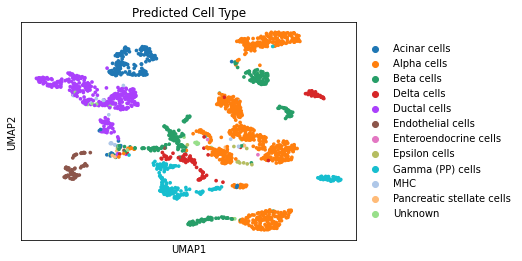

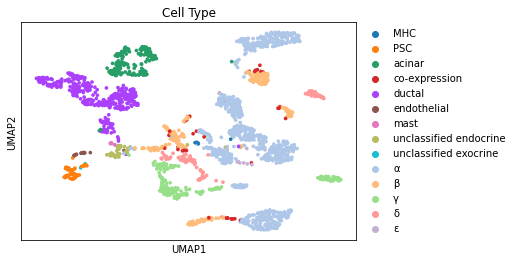

In [ ]:
# UMAP results 
sc.tl.pca(Pancreas_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(Pancreas_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(Pancreas_adata)

sc.pl.umap(Pancreas_adata, color=['Predicted Cell Type'])
sc.pl.umap(Pancreas_adata, color=['Cell Type'])

# GBM 

In [1]:
# Read and process GBM data 
GBM_adata = sc.read_text("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/GBM_LogX.txt", delimiter = '\t', first_column_names=None)
GBM_adata = GBM_adata.T 

# Regress out cell cycle scores
GBMCellCycleScores = pd.read_table("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/GbmCellCycleScores.txt", delimiter = '\t')
GBM_adata.obs['score_S'] = GBMCellCycleScores['score_S'].values
GBM_adata.obs['score_G2M'] = GBMCellCycleScores['score_G2M'].values
sc.pp.regress_out(GBM_adata, ['score_S', 'score_G2M'])

# Scale (zero-center) data
sc.pp.scale(GBM_adata)

# Load ground truth cell type labels 
GBM_Metadata = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/metadata2.csv")
GBM_adata.obs['Cell Type'] = GBM_Metadata['cell_assignment'].values

# Load gene list 
GBMGenes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/features2.tsv",header=None)
GBMGenelist = []
for item in GBMGenes.values.tolist():
  GBMGenelist.append(item[0])
GBM_adata.var_names = GBMGenelist
GBM_adata.var_names

NameError: ignored

In [ ]:
# Extract GBM markers from the Panglao DB marker list 
GBMMarkers = MarkerGeneList.iloc[np.asarray(np.where((MarkerGeneList['cell type'] == 'Oligodendrocytes') | 
                                                    (MarkerGeneList['cell type'] == 'T cells') |
                                                    (MarkerGeneList['cell type'] == 'Macrophages')))[0,:],:]

# Isolate gene symbols and exclude genes not found in the data gene list 
PanglaoDB_GBM = GBMMarkers['official gene symbol']
PanglaoDB_GBM = list(set(PanglaoDB_GBM) & set(GBM_adata.var_names))

# Manually add malignant gene markers 
MalignantGenesPool = ['CD33','CD44','ABCC3','TNFRSF1A','MGMT','IDH1','IDH2','ATRX',
                      'TP53','RB1','PIK3CA','TERT']

# RB1, TERT 

MalignantGenes = []
for g in MalignantGenesPool:
  if ((g in GBM_adata.var_names) & (g not in PanglaoDB_GBM)):
    MalignantGenes.append(g)

# Create data frame for malignant markers
Malignant_df = pd.DataFrame({"official gene symbol":MalignantGenes, "cell type":['Malignant']*len(MalignantGenes)})

# Add malignant markers data frame to Panglao DB list of GBM markers
# *** This is used to create the anndata input *** 
PanglaoDB_GBM = PanglaoDB_GBM + list(Malignant_df['official gene symbol'])
len(PanglaoDB_GBM)

302

In [ ]:
# Create a data frame containing the official gene symbol and cell type for each gene in the input list (PanglaoDB_GBM)
# *** This is used to create the regularization and weight masks *** 
GBMMarkers_list = []
for gene in PanglaoDB_GBM:
  if gene in list(GBMMarkers['official gene symbol']):
    GBMMarkers_list.append({
        'official gene symbol': gene,
        'cell type': GBMMarkers.loc[GBMMarkers['official gene symbol'] == gene, 'cell type'].iloc[0]
    })
        
GBMMarkers = pd.DataFrame(GBMMarkers_list)
GBMMarkers = pd.concat([GBMMarkers, Malignant_df])
len(GBMMarkers)

302

In [ ]:
# Create a variable list for input genes / features 
Panglao_GBM_Input = []

for i in range(GBM_adata.shape[1]):
  if GBM_adata.var_names[i] in PanglaoDB_GBM:
    Panglao_GBM_Input.append(True)
  else: 
    Panglao_GBM_Input.append(False)

GBM_adata.var['input_features'] = Panglao_GBM_Input

# Create anndata input for the model by filtering GBM_adata
GBM_input = GBM_adata[:,GBM_adata.var['input_features']]
GBM_input

View of AnnData object with n_obs × n_vars = 7930 × 302
    obs: 'score_S', 'score_G2M', 'Cell Type'
    var: 'mean', 'std', 'input_features'

In [ ]:
# Creating weight mask for marker genes
marker_genes = GBM_input.var_names
cell_types = pd.unique(GBMMarkers['cell type'])

marker_gene_cell_type_weight_mask = np.zeros((len(marker_genes), len(cell_types)))
for i, gene in enumerate(marker_genes):
  for j, cell_type in enumerate(cell_types):
    is_marker_gene_for_cell_type = \
      GBMMarkers[(GBMMarkers['official gene symbol'] == gene) & 
                      (GBMMarkers['cell type'] == cell_type)].shape[0] > 0
    if is_marker_gene_for_cell_type:   # Mask = 1
      marker_gene_cell_type_weight_mask[i, j] = 1
    else:                              # Mask = 0
      marker_gene_cell_type_weight_mask[i, j] = 0

# Creating marker gene biased regularization mask 
marker_gene_cell_type_reg_penalties = 1 - marker_gene_cell_type_weight_mask

In [ ]:
# Train the model 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
NumGBMCellTypes = len(GBMMarkers['cell type'].unique())
num_genes = GBM_input.shape[1]
autoencoder = Autoencoder(NumGBMCellTypes, num_genes, 
                          marker_gene_cell_type_reg_penalties,
                          marker_gene_cell_type_weight_mask)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
                    loss=losses.MeanSquaredError())

history = autoencoder.fit(GBM_input.X, GBM_input.X,
                          epochs=100,
                          shuffle=True,
                          validation_data=(GBM_input.X, GBM_input.X))

Epoch 1/100
248/248 [==============================] - 3s 7ms/step - loss: 3.8578 - val_loss: 0.9794
Epoch 2/100
248/248 [==============================] - 3s 11ms/step - loss: 0.9634 - val_loss: 0.9524
Epoch 3/100
248/248 [==============================] - 2s 7ms/step - loss: 0.9433 - val_loss: 0.9344
Epoch 4/100
248/248 [==============================] - 2s 7ms/step - loss: 0.9268 - val_loss: 0.9190
Epoch 5/100
248/248 [==============================] - 2s 7ms/step - loss: 0.9124 - val_loss: 0.9057
Epoch 6/100
248/248 [==============================] - 1s 4ms/step - loss: 0.9004 - val_loss: 0.8998
Epoch 7/100
248/248 [==============================] - 1s 4ms/step - loss: 0.8897 - val_loss: 0.8841
Epoch 8/100
248/248 [==============================] - 1s 4ms/step - loss: 0.8794 - val_loss: 0.8750
Epoch 9/100
248/248 [==============================] - 1s 4ms/step - loss: 0.8709 - val_loss: 0.8667
Epoch 10/100
248/248 [==============================] - 1s 5ms/step - loss: 0.8638 - val_l

In [ ]:
# Embed the model 
latent_embedding, mean, var = autoencoder.embed(GBM_input.X)

# assign cell type labels based on maximum probability in the latent layer output 
cell_type_labels = []
for item in latent_embedding:
  cell_type_labels.append(cell_types[np.where(item == max(item))[0][0]])

# compute pValue of each assignment and assign 'unknown' labels according p-value threshold
NumGBMCells = GBM_input.shape[0]
GBM_Assignment_PValues = []
pVal_Threshold = 0.05

for cell in range(NumGBMCells):
    MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
    pVal = []
    for LatentNode in range(NumGBMCellTypes):
      if LatentNode != MaxIndex:
        pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
                                   mean[cell,LatentNode],var[cell,LatentNode],
                                   num_genes))
    GBM_Assignment_PValues.append(pVal[np.argmax(pVal)])
    if pVal[np.argmax(pVal)] > pVal_Threshold:
      print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
      cell_type_labels[cell] = 'Unknown'

GBM_Assignment_PValues = np.array(GBM_Assignment_PValues).ravel()
GBM_adata.obs['GBM pVal'] = GBM_Assignment_PValues
GBM_adata.obs['Predicted Cell Type'] = cell_type_labels

Not Confident: Malignant = 0.12354202076995724
Not Confident: Malignant = 0.05079956922171819
Not Confident: Malignant = 0.08949821205677161
Not Confident: Macrophages = 0.05929295983701754
Not Confident: Macrophages = 0.05560675487081361
Not Confident: Macrophages = 0.05026848566218797
Not Confident: Malignant = 0.06094585803517159
Not Confident: Malignant = 0.328432086503006
Not Confident: Malignant = 0.0763526277747717
Not Confident: Macrophages = 0.06229129214717727
Not Confident: Macrophages = 0.05048007055692605
Not Confident: Malignant = 0.06067215134483307
Not Confident: Malignant = 0.060118186742660965
Not Confident: Macrophages = 0.05143817156640692
Not Confident: Malignant = 0.05351670217962103
Not Confident: Macrophages = 0.05151200330608359
Not Confident: Malignant = 0.07745633189960567
Not Confident: Malignant = 0.06515300123683465
Not Confident: Macrophages = 0.06718293275914983
Not Confident: Macrophages = 0.06241043817416521
Not Confident: Malignant = 0.212141386377222

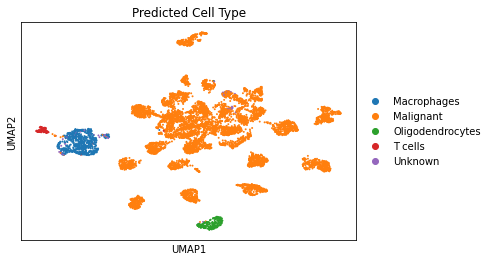

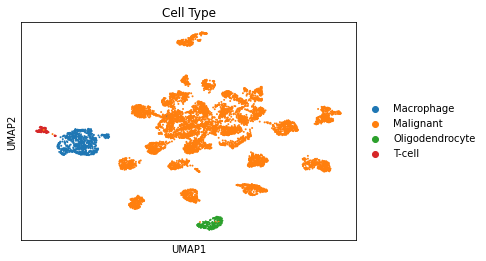

In [ ]:
# Plot UMAP results 
sc.tl.pca(GBM_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(GBM_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(GBM_adata)

sc.pl.umap(GBM_adata, color=['Predicted Cell Type'])
sc.pl.umap(GBM_adata, color=['Cell Type'])